In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.express as px

class DataProcessor:
        def __init__(self, csv_file, target_column, date_column=None):
            self.df = pd.read_csv(csv_file)
            self.target_column = target_column
            self.date_column = date_column
            if self.date_column is not None and self.date_column in self.df.columns:
                self.df[self.date_column] = pd.to_datetime(self.df[self.date_column]).dt.floor('D') 
                
                
                
        def preprocess(self, check_outliers=True):
                """
                Preprocess data for Prophet model
                """
                # Fill missing values and handle NaNs for non-datetime columns
                non_datetime_columns = self.df.select_dtypes(exclude=[np.datetime64]).columns
                self.df[non_datetime_columns] = self.df[non_datetime_columns].apply(lambda x: x.fillna(x.mean()))
                # Check for outliers and remove them if needed
                if check_outliers:
                    numeric_columns = self.df.select_dtypes(include=[np.number]).columns
                    for col in numeric_columns:
                        q1 = self.df[col].quantile(0.25)
                        q3 = self.df[col].quantile(0.75)
                        iqr = q3 - q1
                        self.df = self.df[(self.df[col] >= (q1 - 1.5 * iqr)) & (self.df[col] <= (q3 + 1.5 * iqr))]             
                        #print(self.df)        
                return self.df

        def prophet_evaluate(self, test_size=0.2, random_state=42):
            """
            Evaluate data using Prophet model
            """
           
            # Train-test split
            target_col = self.target_column
            date_col = self.date_column
            df_prophet = self.preprocess(check_outliers=True)            
            df_prophet = df_prophet.rename(columns={date_col: 'ds', target_col: 'y'})            
            df_prophet.set_index('ds',inplace=True)            
            train_size = int((1 - test_size) * len(df_prophet))
            train_df, test_df = df_prophet[:train_size], df_prophet[train_size:]
            train_df, test_df = train_df.reset_index(), test_df.reset_index()

            # Train Prophet model with additional regressors
            model = Prophet()
            for col in train_df.columns:
                if col not in ['ds', 'y']:
                    model.add_regressor(col)
            model.fit(train_df)

            # Make predictions
            future = model.make_future_dataframe(periods=len(test_df), freq='D', include_history=False)
            test_df = test_df.drop_duplicates(subset='ds')  # Drop duplicate date values
            future = future.merge(test_df.drop(columns='y'), on='ds', how='left')
            non_datetime_columns = future.select_dtypes(exclude=[np.datetime64]).columns
            future[non_datetime_columns] = future[non_datetime_columns].apply(lambda x: x.fillna(x.mean()))
            predicted_df = model.predict(future)

            # Evaluate model performance using MSE, RMSE, and R-squared
            mse_pr = mean_squared_error(test_df['y'], predicted_df['yhat'].iloc[:len(test_df)])
            rmse_pr = np.sqrt(mse_pr)
            r_squared_pr = r2_score(test_df['y'], predicted_df['yhat'].iloc[:len(test_df)])

            # Print performance metrics and plot predictions
            print(f"MSE for Prophet model: {mse_pr}")
            print(f"RMSE for Prophet model: {rmse_pr}")
            print(f"R-squared for Prophet model: {r_squared_pr}")
            y_test_pro =test_df['y']
            y_pred_pro = predicted_df['yhat']

            # Return performance metrics
            return mse_pr, rmse_pr, r_squared_pr,y_test_pro,y_pred_pro
         
        

        def lstm_evaluate(self, look_back=7, test_size=0.2, epochs=100, batch_size=32, random_state=42):
            """
            Preprocess and evaluate data using LSTM model
            """
            # Preprocess data for LSTM model
            target_col = self.target_column
            date_col = self.date_column
            df_lstm = self.preprocess(check_outliers=True)  
           
            y = df_lstm[target_col].values
            y = y.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(0, 1))
            y = scaler.fit_transform(y)
            self.scaler = scaler

            dataX, dataY = [], []
            for i in range(len(y)-look_back):
                a = y[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(y[i + look_back, 0])
            dataX = np.array(dataX)
            dataY = np.array(dataY)
            X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=test_size, random_state=random_state)
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

            # Define LSTM model
            model = Sequential()
            model.add(LSTM(4, input_shape=(look_back, 1)))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            # Make predictions
            y_pred = model.predict(X_test)

            # Inverse transform the scaled data to get the original data values
            y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1))

            # Evaluate model performance using MSE, RMSE, and R-squared
            mse_ls = mean_squared_error(y_test_orig, y_pred_orig)
            rmse_ls = np.sqrt(mse_ls)
            r_squared_ls = r2_score(y_test_orig, y_pred_orig)

            # Print performance metrics and plot predictions
            print(f"MSE for LSTM model: {mse_ls}")
            print(f"RMSE for LSTM model: {rmse_ls}")
            print(f"R-squared for LSTM model: {r_squared_ls}")
            y_test_lstm = y_test_orig
            y_pred_lstm = y_pred_orig
            # Return performance metrics
            
            return mse_ls, rmse_ls, r_squared_ls,y_test_lstm,y_pred_lstm

        
        def ensemble_evaluate(self, test_size=0.2, random_state=42, tune_hyperparameters=True, sample_size=None):
            """
            Evaluate ensemble model using stacked regressors and linear regression as the final estimator
            """
            # Preprocess data for ensemble model
            
            #if sample_size is not None:
                #self.df = self.df.sample(n=sample_size, random_state=42)
            target_col = self.target_column
            date_col = self.date_column    
            df_ens=self.preprocess(check_outliers=True)
                       
             # Generate year, month, day columns
            df_ens['year'] =  df_ens[date_col].dt.year
            df_ens['month'] = df_ens[date_col].dt.month
            df_ens['day'] = df_ens[date_col].dt.day
                   
            X = df_ens.drop(columns=[target_col,date_col])
            y = df_ens[target_col]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)           
            if tune_hyperparameters:
                # Hyperparameter tuning for Random Forest
                rf_param_grid = {
                    'n_estimators': [100, 200, 500],
                    'max_features': ['sqrt', 'log2'],
                    'min_samples_split': [2, 4, 8]
                }
                rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, n_jobs=-1)
                rf_grid.fit(X_train, y_train)

                # Hyperparameter tuning for Gradient Boosting
                gb_param_grid = {
                    'n_estimators': [100, 200, 500],
                    'learning_rate': [0.01, 0.1, 1],
                    'max_depth': [3, 5, 7]
                }
                gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=5, n_jobs=-1)
                gb_grid.fit(X_train, y_train)

                # Hyperparameter tuning for XGBoost
                xgb_param_grid = {
                    'n_estimators': [100, 200, 500],
                    'learning_rate': [0.01, 0.1, 1],
                    'max_depth': [3, 5, 7]
                }
                xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=5, n_jobs=-1)
                xgb_grid.fit(X_train, y_train)

                # Train the models with the best hyperparameters
                estimators = [
                    ('rf', rf_grid.best_estimator_),
                    ('gb', gb_grid.best_estimator_),
                    ('xgb', xgb_grid.best_estimator_)
                ]
            else:
                estimators = [
                    ('rf', RandomForestRegressor(random_state=42)),
                    ('gb', GradientBoostingRegressor(random_state=42)),
                    ('xgb', XGBRegressor(random_state=42))
                ]

            # Use stacking regressor with linear regression as the final estimator
            stacking_regressor = StackingRegressor(
                estimators=estimators,
                final_estimator=LinearRegression()
            )

            # Train the stacking regressor
            stacking_regressor.fit(X_train, y_train)

            # Make predictions on test data
            y_pred = stacking_regressor.predict(X_test)

            # Evaluate model performance using MSE, RMSE, and R-squared
            mse_ens = mean_squared_error(y_test, y_pred)
            rmse_ens = np.sqrt(mse_ens)
            r_squared_ens = r2_score(y_test, y_pred)

            # Print performance metrics and plot predictions
            print(f"MSE for Ensemble model: {mse_ens}")
            print(f"RMSE for Ensemble model: {rmse_ens}")
            print(f"R-squared for Ensemble model: {r_squared_ens}")
            y_test_ens = y_test
            y_pred_ens = y_pred
             # Return performance metrics           
    
            return mse_ens, rmse_ens, r_squared_ens, y_test_ens,y_pred_ens


        def select_best_model(self, forecast_period=7):
            """
            Select the best model based on the lowest RMSE and highest R-squared values.
            Plot the predictions of the best model for true vs predicted values and return
            the predictions dataframe with dates from the original dataframe.
            """
            mse_ens, rmse_ens, r_squared_ens, y_test_ens, y_pred_ens = self.ensemble_evaluate()
            mse_pr, rmse_pr, r_squared_pr, y_test_pro, y_pred_pro = self.prophet_evaluate()
            mse_ls, rmse_ls, r_squared_ls, y_test_lstm, y_pred_lstm = self.lstm_evaluate()
            target_col = self.target_column
            date_col = self.date_column

            # Compare models and select the best one
            model_scores = {
                'Ensemble': (rmse_ens, r_squared_ens),
                'Prophet': (rmse_pr, r_squared_pr),
                'LSTM': (rmse_ls, r_squared_ls)
            }

            best_model = min(model_scores, key=lambda x: (model_scores[x][0], -model_scores[x][1]))
            best_rmse, best_r_squared = model_scores[best_model]

            # Print best model and performance metrics
            print(f"The best model is: {best_model}")
            print(f"RMSE for the best model: {best_rmse}")
            print(f"R-squared for the best model: {best_r_squared}")

            # Plot predictions for the best model
            if best_model == 'Prophet':
                y_test = y_test_pro
                y_pred = y_pred_pro
            elif best_model == 'Ensemble':
                y_test = y_test_ens
                y_pred = y_pred_ens
            else:
                y_test = y_test_lstm
                y_pred = y_pred_lstm
           
            df_h = pd.DataFrame({'Date': self.df[date_col].values[-len(y_test):],
                     'True': y_test.ravel(),
                     'Predicted': y_pred.ravel()})
            df_h.plot(x='Date', y=['True', 'Predicted'], figsize=(10, 6))
            plt.xlabel('Date')
            plt.ylabel('Target')
            plt.title(f'True vs Predicted Values ({best_model} Model)')
            plt.show()
            # Create a dataframe with the true values and predictions along with the dates
            df = pd.DataFrame({'Date': self.df[date_col][-forecast_period:].ravel(),
                               'True': y_test[-forecast_period:].ravel(),
                               'Predicted': y_pred[-forecast_period:].ravel()})
            return df



13:19:48 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing


MSE for Prophet model: 8331.64202955614
RMSE for Prophet model: 91.27782879514686
R-squared for Prophet model: -0.8468612372580218
143/143 [==============================] - 0s 784us/step
MSE for LSTM model: 2360.802070982988
RMSE for LSTM model: 48.58808568963165
R-squared for LSTM model: 0.9338377572747195
MSE for Ensemble model: 5758.729345765782
RMSE for Ensemble model: 75.88629221253191
R-squared for Ensemble model: 0.838878556591132
MSE for Ensemble model: 5800.721759397678
RMSE for Ensemble model: 76.16246949382405
R-squared for Ensemble model: 0.8405313281530248


13:53:01 - cmdstanpy - INFO - Chain [1] start processing
13:53:07 - cmdstanpy - INFO - Chain [1] done processing


MSE for Prophet model: 159924.06631785576
RMSE for Prophet model: 399.90507163307615
R-squared for Prophet model: -27.233450446738374
139/139 [==============================] - 0s 886us/step
MSE for LSTM model: 2957.596366843235
RMSE for LSTM model: 54.383787720636334
R-squared for LSTM model: 0.9180747605782147
The best model is: LSTM
RMSE for the best model: 54.383787720636334
R-squared for the best model: 0.9180747605782147


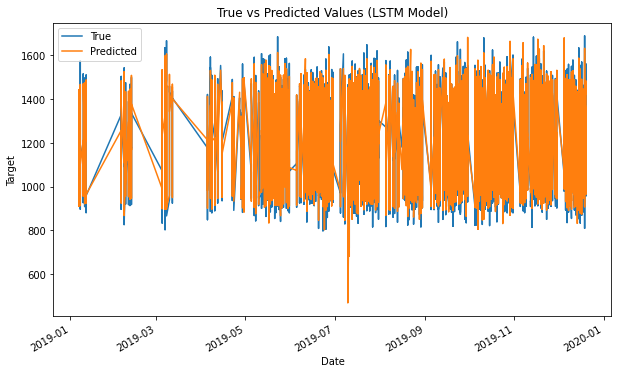

,Date,True,Predicted
0,2019-12-20,1350.7714,1370.780151
1,2019-12-20,1269.4874,1291.780762
2,2019-12-20,1471.0582,1463.229004
3,2019-12-20,1345.2871,1362.090454
4,2019-12-20,1421.8489,1389.818848
5,2019-12-20,1484.8215,1448.305786
6,2019-12-20,1560.0028,1482.147583
7,2019-12-20,1343.7895,1345.837036
8,2019-12-20,1094.8748,1118.497559
9,2019-12-20,1267.8570,1305.023438


In [2]:
# Instantiate the DataProcessor class

csv_file = 'panama.csv'
target_column = 'nat_demand'
date_column = 'datetime'
data = DataProcessor(csv_file, target_column, date_column)

# Preprocess the data
data.preprocess()

# Evaluate the data using the Prophet model
data.prophet_evaluate()

# Evaluate the data using the LSTM model
data.lstm_evaluate()

# Evaluate the data using the ensemble model
data.ensemble_evaluate()

# Select the best model and plot the predictions
data.select_best_model(forecast_period=14)
